In [1]:
#  Required imports

print("Importing standard library")
import math, os, sys, time

print("Importing python data libraries")
import numpy as np
from matplotlib import cm, pyplot as plt
from   scipy import stats

print("Importing third party libraries")
import dill as pickle
import tensorflow as tf

print("Importing custom backends")
sys.path.append("/Users/Ste/PostDoc/git-with-DP/SM-sandbox/proj5.4-EFT-Density-Estimation")
from backends.data_preparation import DataTable
from backends.density_model    import DensityModel, get_sum_gauss_density
from backends.plot             import histo_to_line, plot_data, plot_ratio, plot_pull, get_ratio_1D
from backends.stats            import whiten_axes, unwhiten_axes
from backends.utils            import make_sure_dir_exists_for_filename

from backends import plot as plot, density_model as density_model, VBFZ_analysis as VBFZ

Importing standard library
Importing python data libraries
Importing third party libraries
Importing custom backends


In [2]:
#  Inputs config

target_observable = "pT_ll"

input_fname = "../Data/SM_EWK_1M_rivet_output.pickle"


In [3]:
#  Model config

num_gaussians             = 30
max_epochs                = 1000
batch_size                = 4000
early_stopping_patience   = 10
early_stopping_min_delta  = 0
validation_split          = -1

whitening_num_points      = 200

learning_rate  = 1e-3        # 0.01 for SGD or 0.001 otherwise
optimiser      = "adam"      # SGD, Adam or AdaDelta
load_models    = False
load_whitening = False
save_plots     = True


In [4]:
#  Config variables dependent on chosen observable

obs_white_linear_fraction_data_space = {}
obs_white_linear_fraction_data_space ["Dphi_j_j"] = 0.8
obs_white_linear_fraction_data_space ["Dy_j_j"  ] = 0.8
obs_white_linear_fraction_data_space ["m_jj"    ] = 0.2
obs_white_linear_fraction_data_space ["m_ll"    ] = 0.8
obs_white_linear_fraction_data_space ["pT_j1"   ] = 0.2
obs_white_linear_fraction_data_space ["pT_j2"   ] = 0.2
obs_white_linear_fraction_data_space ["pT_jj"   ] = 0.2
obs_white_linear_fraction_data_space ["pT_ll"   ] = 0.2
obs_white_linear_fraction_data_space ["rap_jj"  ] = 0.2
obs_white_linear_fraction_data_space ["rap_ll"  ] = 0.8

white_linear_fraction_data_space = obs_white_linear_fraction_data_space[target_observable]


In [5]:
#  Configure whitening methods (to loop over)

class whitening_method :
    def __init__ (self, func_form, alpha=0., beta=0., gamma=0., load_file=None, save_file=None, load_model_dir=None, save_model_dir=None) :
        assert func_form in ["step", "gaus"]
        self.func_form      = func_form
        self.alpha          = alpha
        self.beta           = beta
        self.gamma          = gamma
        self.load_file      = load_file
        self.save_file      = save_file
        self.load_model_dir = load_model_dir
        self.save_model_dir = save_model_dir

whitening_gaus = whitening_method("gaus",          load_file=f".white_funcs_paper_gaus_{target_observable}.pickle", save_file=f".white_funcs_paper_gaus_{target_observable}.pickle", load_model_dir=f".EWK_density_model_paper_gaus_{target_observable}", save_model_dir=f".EWK_density_model_paper_gaus_{target_observable}")
whitening_step = whitening_method("step", 4, 3, 1, load_file=f".white_funcs_paper_step_{target_observable}.pickle", save_file=f".white_funcs_paper_step_{target_observable}.pickle", load_model_dir=f".EWK_density_model_paper_step_{target_observable}", save_model_dir=f".EWK_density_model_paper_step_{target_observable}")
whitening_methods = [whitening_step]


In [6]:
#  Configure VBFZ observables

remove_observables =  [obs for obs in VBFZ.all_observables if obs != target_observable] 
VBFZ.configure(remove_observables)
print(f"Configured with {VBFZ.num_observables} observables: " + ", ".join(VBFZ.observables))


Configured with 1 observables: pT_ll


In [7]:
#  Plots config

intervals       = []
minor_intervals = []
x_prime         = 0.

if target_observable is "pT_ll" :
    intervals       = []
    minor_intervals = []
    x_prime         = 500
    
if target_observable is "Dphi_j_j" :
    intervals       = [[-np.pi, r"$-\pi$"], [-3.*np.pi/4., r"$-\frac{3\pi}{4}$"], [-np.pi/2., r"$-\frac{\pi}{2}$"],
                       [-np.pi/4., r"$-\frac{\pi}{4}$"], [0, "$0$"], [np.pi/4., r"$\frac{\pi}{4}$"],
                       [np.pi/2., r"$\frac{\pi}{2}$"], [3.*np.pi/4., r"$\frac{3\pi}{4}$"], [np.pi, r"$\pi$"]]
    minor_intervals = [(i-16.)*np.pi/16. for i in range(32) if i % 4 != 0]
    x_prime         = 0.8

if target_observable is "m_jj" :
    intervals       = []
    minor_intervals = []
    x_prime         = 2500

if target_observable is "Dy_j_j" :
    intervals       = []
    minor_intervals = []
    x_prime         = 4.


In [8]:
#  Load and format the data
#

data_table = VBFZ.load_table(input_fname, transform=True)


Loading events from file ../Data/SM_EWK_1M_rivet_output.pickle
 -- Table created with 1000000 events
 -- filtering observable m_ll between 75 and 105
 -- 660799 events survived
 -- filtering observable pT_ll between 0 and 900
 -- 660766 events survived
 -- filtering observable theta_ll between 0 and 3.141592653589793
 -- 660766 events survived
 -- filtering observable rap_ll between 0 and 2.2
 -- 652255 events survived
 -- filtering observable m_jj between 150 and 5000
 -- 643177 events survived
 -- filtering observable pT_jj between 0 and 900
 -- 643177 events survived
 -- filtering observable theta_jj between 0 and 3.141592653589793
 -- 643177 events survived
 -- filtering observable rap_jj between 0 and 4.4
 -- 643177 events survived
 -- filtering observable pT_j1 between 40 and 1200
 -- 643054 events survived
 -- filtering observable pT_j2 between 40 and 1200
 -- 641867 events survived
 -- filtering observable Dy_j_j between 0 and 8.8
 -- 641867 events survived
 -- filtering observ

In [9]:

for white_meth in whitening_methods :
    print(f"Preparing to whiten dataset using method: {white_meth.func_form} [alpha={white_meth.alpha} beta={white_meth.beta} gamma={white_meth.gamma}]")
    
    whitening_funcs = None
    if (load_whitening) and (type(white_meth.load_file) != type(None) and (os.path.isfile(white_meth.load_file))) :
        print(f"Loading whitening functions from file {white_meth.load_file}")
        whitening_funcs = pickle.load(open(white_meth.load_file, "rb"))

    axis_configs = [[VBFZ.transformed_observable_limits[target_observable][0], VBFZ.transformed_observable_limits[target_observable][1], whitening_num_points,  white_linear_fraction_data_space, 0.]]
            
    print(f"Whitening dataset")
    white_meth.physical_data, white_meth.weights, white_meth.white_data = {}, {}, {}
    white_meth.physical_data [.1], white_meth.weights [.1] = data_table.get_observables_and_weights()
    white_meth.white_data[.1], whitening_funcs = whiten_axes (data_table.data, data_table.types, axis_configs=axis_configs, whitening_funcs=whitening_funcs, weights=data_table.get_weights(), 
                                                              func_form=white_meth.func_form, alpha=white_meth.alpha, beta=white_meth.beta, gamma=white_meth.gamma)
            
    print(f"Whitening intervals")
    if len(intervals) > 0 :
        white_meth.white_intervals = whiten_axes (np.array([[i[0]] for i in intervals]), data_table.types, axis_configs=axis_configs, whitening_funcs=whitening_funcs, weights=[1 for i in intervals], 
                                                  func_form=white_meth.func_form, alpha=white_meth.alpha, beta=white_meth.beta, gamma=white_meth.gamma)[0]
    else : white_meth.white_intervals = []
    
    print(f"Whitening minor intervals")
    if len(minor_intervals) > 0 :
        white_meth.white_minor_intervals = whiten_axes (np.array([[i] for i in minor_intervals]), data_table.types, axis_configs=axis_configs, whitening_funcs=whitening_funcs, weights=[1 for i in minor_intervals], 
                                                        func_form=white_meth.func_form, alpha=white_meth.alpha, beta=white_meth.beta, gamma=white_meth.gamma)[0]
    else : white_meth.white_minor_intervals = []
    
    if type(white_meth.save_file) != type(None) :
        print(f"Saving whitening functions to file {white_meth.save_file}")
        pickle.dump(whitening_funcs, open(white_meth.save_file, "wb"))
        
    white_meth.whitening_funcs = whitening_funcs
        

Preparing to whiten dataset using method: step [alpha=4 beta=3 gamma=1]
Whitening dataset
Whitening intervals
Whitening minor intervals
Saving whitening functions to file .white_funcs_paper_step_pT_ll.pickle


In [10]:
#  Set sum-of-weights to unity
#

for white_meth in whitening_methods :
    white_meth.weights_to_fit = {k:i/np.sum(i) for k,i in white_meth.weights.items()}
    

In [11]:
#  Save numbers required to plot whitening function
#

for white_meth in whitening_methods :

    alpha, beta , gamma      = white_meth.alpha, white_meth.beta, white_meth.gamma
    axmin, axmax, ax_npoints = VBFZ.transformed_observable_limits[target_observable][0], VBFZ.transformed_observable_limits[target_observable][1], whitening_num_points
    ax_scan_points           = np.linspace(axmin, axmax, 1+ax_npoints)
    data_frac_constant       = white_linear_fraction_data_space
    gauss_frac_constant      = 0.
    dataset   = white_meth.physical_data[.1][:,0]
    weights   = white_meth.weights      [.1]
    ds_and_w  = np.array([(x,w) for x, w in zip(dataset, weights) if (x>axmin and x<axmax)])
    dataset, weights = [x[0] for x in ds_and_w], [x[1] for x in ds_and_w]
    weights   = weights / np.sum(weights)
    func_form = white_meth.func_form
        
    print("Getting data c.d.f.")
    data_cdf = []
    for A in ax_scan_points :
        sys.stdout.write(f"\rScan point is: {A:.4f}  ----------")
        data_cdf.append(np.sum([w for x,w in zip(dataset, weights) if x < A]))
    data_cdf     = np.array(data_cdf)
    constant_cdf = (ax_scan_points - axmin) / (axmax - axmin)
    combined_cdf = data_frac_constant*constant_cdf + (1-data_frac_constant)*data_cdf
    
    white_meth.ax_scan_points = ax_scan_points
    white_meth.cdf_data, white_meth.cdf_data_linear, white_meth.cdf_x = data_cdf, constant_cdf, combined_cdf

    print("\nGetting latent c.d.f.")
    if func_form == "step" :
        white_space_x   = np.linspace(-5, 5, 201)
        Smooth_step_y   = 1. / (1 + np.exp((white_space_x-beta)*alpha-gamma)) / (1 + np.exp(-(white_space_x+beta)*alpha-gamma))
        white_meth.white_space_y = Smooth_step_y
        Smooth_step_cdf = np.array([np.sum(Smooth_step_y[:i+1]) for i in range(len(Smooth_step_y))])
        Smooth_step_cdf = Smooth_step_cdf / Smooth_step_cdf[-1]
        Smooth_step_cdf[0] = 0.
        constant_cdf    = (white_space_x + 5.) / 10.
        white_space_cdf = gauss_frac_constant*constant_cdf + (1-gauss_frac_constant)*Smooth_step_cdf
        white_meth.cdf_target    = Smooth_step_cdf
        white_meth.white_space_x = white_space_x
    else :
        white_space_x   = np.linspace(-5, 5, 201)
        white_meth.white_space_y = stats.norm.pdf(white_space_x)
        Gauss_cdf       = stats.norm.cdf(white_space_x)
        Gauss_cdf[0], Gauss_cdf[-1] = 0., 1.
        constant_cdf    = (white_space_x + 5.) / 10.
        white_space_cdf = gauss_frac_constant*constant_cdf + (1-gauss_frac_constant)*Gauss_cdf 
        white_meth.cdf_target    = Gauss_cdf
        white_meth.white_space_x = white_space_x
        
    white_meth.white_space_x = white_space_x
    white_meth.cdf_latent_linear, white_meth.cdf_u = constant_cdf, white_space_cdf
    
    print("Done")


Getting data c.d.f.
Scan point is: 900.0000  ----------
Getting latent c.d.f.
Done


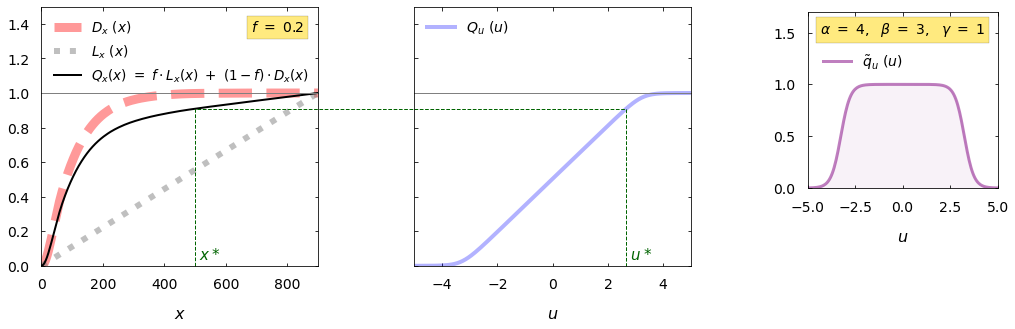

In [12]:
#  Plot whitening functions
#

for white_meth in whitening_methods :
    y_prime = np.interp(x_prime, white_meth.ax_scan_points, white_meth.cdf_x        )
    u_prime = np.interp(y_prime, white_meth.cdf_u         , white_meth.white_space_x)
    
    fig    = plt.figure(figsize=(14., 0.8*4.5))
    ax     = fig.add_axes([0.01, 0.01, 0.32*12./14., 1.])
    plot_x = white_meth.ax_scan_points
    ax.plot(plot_x, white_meth.cdf_data        , "-", linestyle="--", lw=9, c="r"   , alpha=0.4, label="$D_x~(x)$")
    ax.plot(plot_x, white_meth.cdf_data_linear , "-", linestyle=":" , lw=6, c="grey", alpha=0.5, label="$L_x~(x)$")
    ax.plot(plot_x, white_meth.cdf_x           , "-", linestyle="-" , lw=2, c="k"   , label="$Q_x(x) ~=~ f\cdot L_x(x) ~+~ (1-f)\cdot D_x(x)$")
    ax.axhline(1, linestyle="-", color="grey", linewidth=1)
    ax.set_xlim([plot_x[0], plot_x[-1]])
    ax.set_ylim([0        , 1.5])
    ax.tick_params(axis="both", right=True, top=True, direction="in", labelsize=14, pad=12)
    ax.set_xlabel("$x$"   , fontsize=16, labelpad=15)
    ax.legend(loc="upper left", fontsize=13.5, frameon=False)
    ax.plot([x_prime, x_prime, 2*plot_x[-1]-plot_x[0]], [0, y_prime, y_prime], "--", c="darkgreen", lw=1, clip_on=False)
    ax.text(x_prime, 0.02, " $x*$", ha="left", va="bottom", fontsize=15, c="darkgreen")
    ax.text(0.95, 0.95, f"$f~=~{white_linear_fraction_data_space:.1f}$", ha="right", va="top", fontsize=14, transform=ax.transAxes, bbox=dict(facecolor="gold", alpha=0.5, linewidth=0.3))
    
    ax     = fig.add_axes([0.38, 0.01, 0.32*12./14., 1.])
    plot_x = white_meth.white_space_x
    ax.plot(plot_x, white_meth.cdf_u, "-", linestyle="-" , lw=4, c="b", label="$Q_u~(u)$", alpha=0.3)
    ax.axhline(1, linestyle="-", color="grey", linewidth=1)
    ax.set_xlim([plot_x[0], plot_x[-1]])
    ax.set_ylim([0        , 1.5])
    ax.tick_params(axis="both", right=True, top=True, direction="in", labelsize=14, pad=12)
    ax.get_yaxis().set_ticklabels([])
    ax.set_xlabel("$u$"   , fontsize=16, labelpad=15)
    ax.legend(loc="upper left", fontsize=14, frameon=False)
    ax.plot([plot_x[0], u_prime, u_prime], [y_prime, y_prime, 0], "--", c="darkgreen", lw=1, clip_on=False)
    ax.text(u_prime, 0.02, " $u*$", ha="left", va="bottom", fontsize=15, c="darkgreen")
    
    ax     = fig.add_axes([0.77, 0.31, 0.22*12./14., 0.68])
    ax.plot(white_meth.white_space_x, white_meth.white_space_y, "-", linestyle="-", lw=3, c="purple", label=r"${\tilde q}_u~(u)$", alpha=0.5)
    ax.fill_between(white_space_x, np.zeros(shape=white_meth.white_space_x.shape), white_meth.white_space_y, color="purple", alpha=0.05)
    ax.set_xlim([white_space_x[0], white_space_x[-1]])
    maxy = 1.7*np.max(white_meth.white_space_y)
    ax.set_ylim([0        , maxy])
    ax.tick_params(axis="both", right=True, top=True, direction="in", labelsize=14, pad=12)
    ax.set_xlabel("$u$"   , fontsize=16, labelpad=15)
    ax.legend(loc=(0.05, 0.63), fontsize=14, frameon=False) 
    ax.text(0.5, 0.95, r"$\alpha~="+f"~{white_meth.alpha:.0f}"+r",~~\beta ~="+f"~{white_meth.beta :.0f}"+r",~~\gamma~="+f"~{white_meth.gamma:.0f}$", ha="center", va="top", fontsize=14, transform=ax.transAxes, bbox=dict(facecolor="gold", alpha=0.5, linewidth=0.3))
    
    plt.subplots_adjust(wspace=0.2, left=0.01, right=0.99)
    if save_plots :
        plt.savefig(f"figures/paper0D_model/projection_functions_{target_observable}.pdf", bbox_inches="tight")
    plt.show()

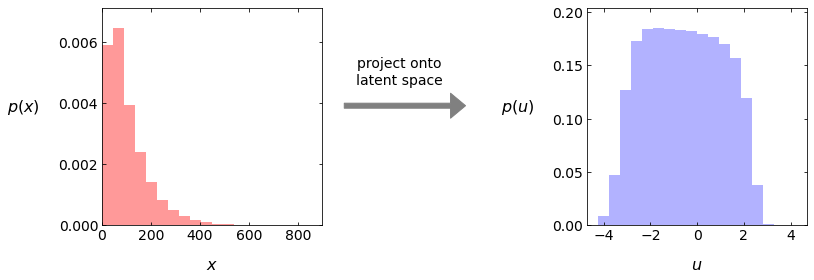

In [13]:
#  Plot original / latent distributions
#

for white_meth in whitening_methods :
    fig = plt.figure(figsize=(10, 4))

    ax   = fig.add_subplot(1, 2, 1)
    bins = np.linspace(VBFZ.transformed_observable_limits[target_observable][0], VBFZ.transformed_observable_limits[target_observable][1], 21)
    vals, _, _ = ax.hist(white_meth.physical_data[.1], weights=white_meth.weights[.1], bins=bins, density=True, color="r", alpha=0.4)
    hmax = 1.1 * np.max(vals)
    ax.set_xlim([bins[0], bins[-1]])
    ax.set_ylim([0      , hmax])
    ax.tick_params(axis="both", right=True, top=True, direction="in", labelsize=14)
    ax.set_ylabel("$p(x)$", fontsize=16, labelpad=35, rotation=0)
    ax.set_xlabel("$x$"   , fontsize=16, labelpad=15)
    
    for idx, i in enumerate(intervals) :
        lw = 2.+2*np.fabs(math.floor(len(intervals)/2.)-idx)/len(intervals)
        ax.axvline(i[0], linestyle="--", c="grey", linewidth=lw)
        ax.text(i[0], 1.1*hmax, i[1], c="grey", fontsize=12, ha="center")
        ax.plot([i[0], i[0]], [hmax, 1.05*hmax], linestyle="--", c="grey", linewidth=lw, clip_on=False)
    
    for i in minor_intervals :
        ax.axvline(i, linestyle=":", c="grey", linewidth=1.)
        
    ax   = fig.add_subplot(1, 2, 2)
    edge = np.max(np.fabs(white_meth.white_data[.1]))
    bins = np.linspace(-edge, edge, 21)
    vals , _, _ = ax.hist(white_meth.white_data[.1], weights=white_meth.weights[.1], bins=bins, density=True, color="b", alpha=0.3)
    hmax = 1.1 * np.max(vals)
    ax.set_xlim([np.min(np.concatenate([bins, [i[0] for i in white_meth.white_intervals]])), np.max(np.concatenate([bins, [i[0] for i in white_meth.white_intervals]]))])
    ax.set_ylim([0      , hmax])
    ax.tick_params(axis="both", right=True, top=True, direction="in", labelsize=14)
    ax.set_ylabel("$p(u)$", fontsize=16, labelpad=35, rotation=0)
    ax.set_xlabel("$u$"   , fontsize=16, labelpad=15)
    
    for idx, (i, wi) in enumerate(zip(intervals, white_meth.white_intervals)) :
        lw = 2.+2*np.fabs(math.floor(len(intervals)/2.)-idx)/len(intervals)
        ax.axvline(wi[0], linestyle="--", c="grey", linewidth=lw)
        xlo, xhi, xrange = bins[0], bins[-1], bins[-1] - bins[0]
        label_pos        = xlo + xrange*(idx/(len(intervals)-1.)), 1.1*hmax, 1.05*hmax
        line_pos         = wi[0], hmax
        ax.text(label_pos[0], label_pos[1], i[1], c="grey", fontsize=12, ha="center")
        ax.plot([line_pos[0], label_pos[0]], [line_pos[1], label_pos[2]], linestyle="--", c="grey", linewidth=lw, clip_on=False)
        
    for wi in white_meth.white_minor_intervals :
        ax.axvline(wi, linestyle=":", c="grey", linewidth=1.)
        
    ax.text(-0.85, 0.65, "project onto\nlatent space", transform=ax.transAxes, ha="center", fontsize=14)
    
    ax.annotate("", xy=(-0.55, 0.55), xycoords  ="axes fraction",
                xytext=(-1.1 , 0.55), textcoords="axes fraction",
                arrowprops=dict(width=5, headwidth=25, headlength=15, facecolor="grey", edgecolor="grey"))
    
    plt.subplots_adjust(wspace=1.2, left=0.01, right=0.99)
    if save_plots :
        plt.savefig(f"figures/paper0D_model/projection_distributions_{target_observable}.pdf", bbox_inches="tight")
    plt.show()
    

In [14]:
#  Plotting mixture of Gaussians, since it was observed that -ve deviations around SM are hard to model
#       if the distribution is dominated by a single Gaussian mode

def plot_mixture_model (savefig=None, log=False) :

    colours   = cm.get_cmap('brg', num_gaussians)   # 'hsv'
    newcolors = colours(np.linspace(0, 1, num_gaussians))
    x         = np.linspace(-6, 6, 241)
    bins      = np.linspace(-6, 6, 61)

    for white_meth in whitening_methods :
        
        fig, ((ax0), (ax2)) = plt.subplots(2, 1, figsize=(8, 8), sharex=True, gridspec_kw={'height_ratios': [2, 1]})

        density_model = white_meth.density_model

        params = density_model.likelihood_models[0].get_gauss_params([[.1]])[0]
        fracs  = params[:num_gaussians]
        means  = params[num_gaussians:2*num_gaussians]
        sigmas = params[2*num_gaussians:3*num_gaussians]

        ds, weights = white_meth.white_data[.1][:,0], white_meth.weights_to_fit[.1]

        y1, int1 = 0., 0.
        bin_entries , _  = np.histogram(ds, weights=weights, bins=bins)
        bin_variance, _  = np.histogram(ds, weights=weights*weights, bins=bins)
        frac_errors      = np.sqrt(bin_variance) / bin_entries
        hvals1, _, _     = ax0.hist(ds, weights=weights, density=True, color="darkgrey", alpha=0.5, bins=bins, label=r"MG5 events")
        for i in range(num_gaussians) :
            yp   = fracs[i]*stats.norm.pdf(x, means[i], sigmas[i])
            y1   = y1 + yp
            int1 = int1 + np.array([fracs[i]*(stats.norm.cdf(bins[j+1], means[i], sigmas[i])-stats.norm.cdf(bins[j], means[i], sigmas[i]))/(bins[j+1]-bins[j]) for j in range(len(bins)-1)])
            ax0.plot(x, yp, c=newcolors[i], linewidth=1, linestyle="--")
        ax0.plot(x, y1, c="k", linewidth=3, linestyle="--", label=r"$p_\phi~(~u~)$")

        ax0.tick_params(axis="both", right=True, top=True, direction="in", labelsize=14)
        ax0.set_ylabel("$p(u)$", fontsize=16, labelpad=45, rotation=0)
        ax0.legend(loc="upper left", frameon=False, fontsize=14, ncol=2)

        rat_x, rat_y, rat_ey = [], [], []
        for idx, b in enumerate(bins) :
            rat_x.append(b)
            if (idx==0) or (idx==len(bins)-1) : continue
            rat_x.append(b)
        for y, ey in zip(hvals1/int1 - 1, frac_errors*hvals1/int1) :
            rat_y .append(y )
            rat_y .append(y )
            rat_ey.append(ey)
            rat_ey.append(ey)
        rat_x, rat_y, rat_ey = np.array(rat_x), np.array(rat_y), np.array(rat_ey)

        ax2.axhline(0, linestyle="--", c="k", linewidth=3)
        ax2.axhline(-0.10, linestyle=":" , c="grey", linewidth=1)
        ax2.axhline(-0.05, linestyle=":" , c="grey", linewidth=1)
        ax2.axhline(0.05 , linestyle=":" , c="grey", linewidth=1)
        ax2.axhline(0.10 , linestyle=":" , c="grey", linewidth=1)
        ax2.set_yticks([-0.1, 0, 0.1])
        ax2.yaxis.set_ticklabels(["$-10\%$", "$0$", "$+10\%$"])
        ax2.plot(rat_x, rat_y, "-", c="darkgrey")
        ax2.fill_between(rat_x, rat_y-rat_ey, rat_y+rat_ey, color="darkgrey", alpha=0.5)
        ax2.tick_params(axis="both", right=True, top=True, direction="in", labelsize=14)
        ax2.set_xlabel("$u$"   , fontsize=18, labelpad=15)
        ax2.set_ylabel(r"$\frac{p(u)~-~p_\phi(u)}{p_\phi(u)}$", fontsize=21, labelpad=70, rotation=0)
        ax2.set_ylim  ([-0.15, 0.15])

        ax0.set_xlim([x[0], x[-1]])
        hmin, hmax = np.min([v for v in hvals1 if v > 0]), np.max(hvals1)
        hrange = hmax - hmin
        ax0.set_ylim([0, 1.4*hmax])
        
        if log : 
            hrange = hmax / hmin
            ax0.set_yscale("log")
            ax0.set_ylim([np.exp(1.2*np.log(hmin) - 0.2*np.log(hmax)), np.exp(1.4*np.log(hmax) - 0.4*np.log(hmin))])

        if type(savefig) is str :
            plt.savefig(savefig, bbox_inches="tight")
        plt.show()


INFO       DensityModel.construct      Set model name              : EWK_Zjj_density_model_pT_ll
INFO       DensityModel.construct      Set model num_gaussians     : 30
INFO       DensityModel.construct      Set model num_conditions    : 1
INFO       DensityModel.construct      Set model num_observables   : 1
INFO       DensityModel.construct      Set observable types        : [<class 'float'>]
INFO       DensityModel.construct      Set bias_initializer        : zeros
INFO       DensityModel.construct      Set learning_rate           : 0.001
INFO       DensityModel.construct      Set learning_rate_evo_factor: 1.0
INFO       DensityModel.construct      Set optimiser               : adam
INFO       DensityModel.construct      Set activation              : leakyrelu
INFO       DensityModel.construct      Set min_gauss_amplitude_frac: 0.0
INFO       DensityModel.build          Building model segment: EWK_Zjj_density_model_pT_ll_observable0 for observable index 0
Creating continuous density

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in true_divide


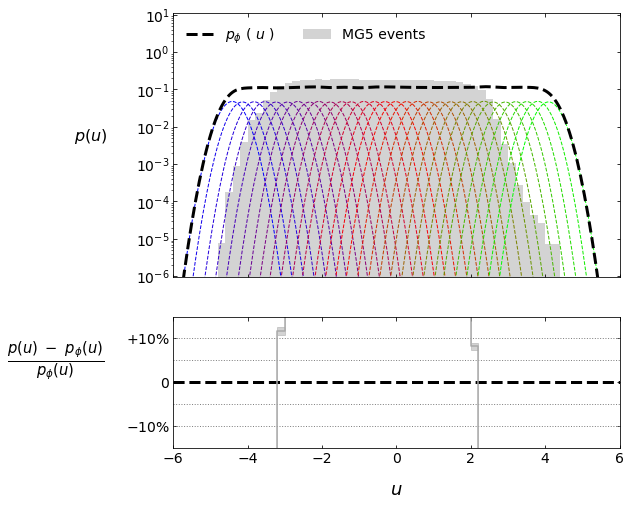

Evaluating losses  (attempt 1 / 100)
-  observable logL are [-2.17471566], combined is -2.1747156550654565
-  eval completed in 15s
INFO       DensityModel.fit            Queued the following observable indices to train: 0
INFO       DensityModel.fit            Parsing training data
INFO       DensityModel.fit            Training observable index 0
INFO       DensityModel.fit              -  Training setting: epochs = 1000
INFO       DensityModel.fit              -  Training setting: batch_size = 4000
INFO       DensityModel.fit              -  Training setting: validation_split = -1
INFO       DensityModel.fit              -  Training setting: early_stopping_patience = 10
INFO       DensityModel.fit              -  Training setting: early_stopping_min_delta = 0
Train on 641867 samples
Epoch 1/1000
641867/641867 [==============================] - 3s 5us/sample - loss: 3.3880e-06
Epoch 2/1000
641867/641867 [==============================] - 3s 5us/sample - loss: 3.3875e-06
Epoch 3/1000


KeyboardInterrupt: 

In [16]:
#  Load model if requested, otherwise build and fit
#

density_model.Gauss_width_reduction_factor = 1

for white_meth in whitening_methods :
    #
    #  Load model if requested
    #
    if (type(white_meth.load_model_dir) != type(None)) and (os.path.exists(white_meth.load_model_dir)) and (load_models) :
        white_meth.density_model = DensityModel.from_dir(white_meth.load_model_dir)
    else :
        #
        #   Figure out the limits of the observables
        #
        all_data = np.concatenate([item[:,0] for c,item in white_meth.white_data.items()])
        min_dp, max_dp = np.min(all_data), np.max(all_data)
        range_dp_per_gauss = (max_dp - min_dp) / num_gaussians
        white_observables_limits = [[min_dp + range_dp_per_gauss, max_dp - range_dp_per_gauss]]
        #
        #   Create density model  
        #
        white_meth.density_model = DensityModel(name               = f"EWK_Zjj_density_model_{target_observable}", 
                                                num_gaussians      = num_gaussians                             , 
                                                num_conditions     = 1                                         , 
                                                num_observables    = 1                                         , 
                                                types              = [float]                                   ,
                                                observables_limits = white_observables_limits                  ,
                                                gauss_mean_scale   = 1./16.                                    ,
                                                gauss_frac_scale   = 1./16.                                    ,
                                                gauss_sigma_scale  = 1./16.                                    ,
                                                optimiser          = optimiser                                 ,
                                                learning_rate      = learning_rate                             ) 
        plot_mixture_model(log=True)
        #
        #   Make sure initial state has no NaN/Inf loss
        #
        white_meth.density_model.ensure_valid_over_dataset (white_meth.white_data, white_meth.weights_to_fit)
        #
        #   Fit density model
        #
        white_meth.density_model.fit(white_meth.white_data                                , 
                                     white_meth.weights_to_fit                            ,
                                     max_epochs_per_observable = max_epochs               ,
                                     early_stopping_patience   = early_stopping_patience  ,
                                     early_stopping_min_delta  = early_stopping_min_delta ,
                                     validation_split          = validation_split         ,
                                     batch_size_per_observable = batch_size               )


In [ ]:
#  Plot postfit Gaussian mixture model
#  -  want this to be composed of many narrow Gaussian modes, not be dominated by wide ones

plot_mixture_model(log=True)


In [ ]:

for white_meth in whitening_methods :
        #
        #   Fit density model
        #
        white_meth.density_model.fit(white_meth.white_data                                , 
                                     white_meth.weights_to_fit                            ,
                                     max_epochs_per_observable = max_epochs               ,
                                     early_stopping_patience   = early_stopping_patience  ,
                                     early_stopping_min_delta  = early_stopping_min_delta ,
                                     validation_split          = validation_split         ,
                                     batch_size_per_observable = batch_size               )

In [ ]:
#  Plot postfit Gaussian mixture model
#  -  want this to be composed of many narrow Gaussian modes, not be dominated by wide ones

plot_mixture_model(log=True)


In [ ]:
#  Sample and unwhiten some datapoints from the model

n_gen = 10000000

for white_meth in whitening_methods :
    print(f"Generating {n_gen} fake datapoints")
    start = time.time()
    white_meth.fake_white_datapoints = white_meth.density_model.sample(n_gen, [.1], n_processes=8)
    print(f"{n_gen} datapoints generated in {int(time.time()-start):.0f}s")
    print("Unwhitening fake datapoints")
    start = time.time()
    white_meth.fake_transformed_datapoints = unwhiten_axes(white_meth.fake_white_datapoints, white_meth.whitening_funcs)
    print(f"{n_gen} datapoints unwhitened in {int(time.time()-start):.0f}s")
    

In [ ]:
#  Compare datapoints before whitening 

for white_meth in whitening_methods :
    #  Create plot
    fig = plt.figure(figsize=(8, 8))
    #  Create top axes
    ax  = fig.add_axes([0, 0.4, 1, 0.6])
    #  Get data
    physical_limits     = np.array(VBFZ.transformed_observable_limits[target_observable])
    log_physical_limits = np.log(physical_limits + 10)
    logx, bins = False, np.linspace(physical_limits[0], physical_limits[1], 41)
    if (target_observable[:2] == "pT") or (target_observable == "m_jj") :
        bins = np.exp(np.linspace(log_physical_limits[0], log_physical_limits[1], 81)) - 10
        if np.fabs(bins[0]) < 1e-9 : bins[0] = 0
        logx = True
    weights = data_table.get_weights()
    true_vals, _ = np.histogram(data_table.data.flatten(), weights=weights, bins=bins)
    true_errs, _ = np.histogram(data_table.data.flatten(), weights=weights*weights, bins=bins)
    true_errs    = np.sqrt(true_errs) / np.sum(true_vals)
    true_vals    = true_vals / np.sum(true_vals)
    fake_vals, _ = np.histogram(white_meth.fake_transformed_datapoints, bins=bins)
    fake_errs    = np.sqrt(fake_vals) / np.sum(fake_vals)
    fake_vals    = fake_vals / np.sum(fake_vals)
    bin_widths   = bins[1:] - bins[:-1]
    #  Plot data
    x_true, y_true, ey_true = histo_to_line(bins, true_vals/bin_widths, true_errs/bin_widths)
    x_fake, y_fake, ey_fake = histo_to_line(bins, fake_vals/bin_widths, fake_errs/bin_widths)
    ax.plot(x_true, y_true, "-", color="darkred" )
    ax.plot(x_fake, y_fake, "-", color="darkblue")
    ax.fill_between(x_true, y_true - ey_true, y_true + ey_true, alpha=0.4, color="darkred" )
    ax.fill_between(x_fake, y_fake - ey_fake, y_fake + ey_fake, alpha=0.4, color="darkblue")
    #  Format axes
    ax.set_xlim(physical_limits[0], physical_limits[1])
    ax.set_yscale("log")
    ax.xaxis.set_ticklabels([])
    ax.tick_params(which="both", direction="in", right=True, top=True, labelsize=16)
    if logx : ax.set_xscale("function", functions=(lambda x : x**(1./2.), lambda x : x*x) )
    #  Create bottom axes
    ax  = fig.add_axes([0, 0, 1, 0.4])
    #  Plot data
    ax.plot(x_true, y_true / y_fake, "-", color="darkred" )
    ax.plot(x_fake, y_fake / y_fake, "-", color="darkblue")
    ax.fill_between(x_true, (y_true - ey_true) / y_fake, (y_true + ey_true) / y_fake, alpha=0.4, color="darkred" )
    ax.fill_between(x_fake, (y_fake - ey_fake) / y_fake, (y_fake + ey_fake) / y_fake, alpha=0.4, color="darkblue")
    for h in [0.85, 0.9, 0.95, 1, 1.05, 1.1, 1.15] :
        ax.axhline(h, ls="--", color="grey", lw=1)
    #  Format axes
    ax.set_xlim(physical_limits[0], physical_limits[1])
    ax.set_ylim(0.8, 1.2)
    ax.tick_params(which="both", direction="in", right=True, top=True, labelsize=16)
    if logx : ax.set_xscale("function", functions=(lambda x : x**(1./2.), lambda x : x*x) )
    #  Show plot
    plt.show()
    

In [ ]:
#  Save model if requested

for white_meth in whitening_methods :
    if type(white_meth.save_model_dir) != type(None) :
        white_meth.density_model.save_to_dir(white_meth.save_model_dir)
        

In [ ]:
A = np.array([[1], [2], [3]])

np.sum(A, axis=0)